# Introduction to Dask

In [1]:
import dask
import time

In [2]:
def square(n):
    time.sleep(1)
    return n * n
    
def add(m, n):
    time.sleep(1)
    return m * n

In [3]:
%%time 

x = square(1)
y = square(2)
z = add(x, y)

CPU times: user 707 µs, sys: 32 µs, total: 739 µs
Wall time: 3 s


## Building a computational graph
***

In [4]:
x = dask.delayed(square)(1)
y = dask.delayed(square)(2)
z = dask.delayed(add)(x, y)

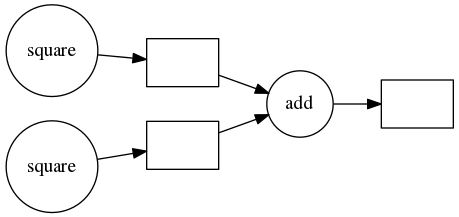

In [5]:
z.visualize(rankdir='LR')

In [6]:
%%time
z.compute()

CPU times: user 5.24 ms, sys: 1.2 ms, total: 6.44 ms
Wall time: 2.01 s


4

***
<mark>Question</mark> Rewrite the following cell so it's executed lazily.
 * Which functions should be delayed? `square`? `sum`? Both of them? Why?
 * Visualize the graph.
 * Compare the execution time with the sequential execution.

In [7]:
x = [square(i) for i in range(10)]
y = sum(x)
y

285

# Multithreaded Cityblock distance matrix function with SciPy and Dask's delayed execution

In this notebook we implement a function to compute the cityblock distance matrix using `scipy.spatial.distance.cdist`. Althought this function is quite fast, it uses a single thread. In cases like this one, it might be convenient to implement a multithreaded version of the function by parallelicing the execution over chunks of data. We are going to use `dask.delayed` to do that.

In [8]:
import numpy as np
from scipy.spatial.distance import cdist
from dask import compute, delayed, visualize

In [9]:
nsamples = 12000
nfeat = 50

x = 10. * np.random.random([nsamples, nfeat])

Let's time the `cdist` function and look the `top` command.

In [10]:
# observe here that the funcion `cdist` used to get the cityblock distance
# is not multithreaded

%timeit cdist(x, x, 'cityblock')

3.69 s ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


With the `top` command we see that `cdist` runs in a single thread. In such cases it could be quite simple write a distributed version of the function. We can do this very easily with `dask.delayed`!

## Dask's async delayed execution
A simple distributed version of `cdist` can be done as the following:
  * Split the array of vectors into chunks. We can use `np.split(x, num_chunks)`
  * Compute partial cityblock distance matrices of the complete array with respect to each of the chunks
  * Concatenate the resulting list into a single cityblock distance matrix.

Note that concatenation is not a fast operation, so probably we will have to continue improving our function.

In [11]:
# define the list of operations to be performed asynchronously
chunks = 12  # we choose on chunk for physical cpu (gpu partition)
partial_distances = [delayed(cdist)(x, xi, 'cityblock') for xi in np.split(x, chunks)]

# at this point nothing is executed

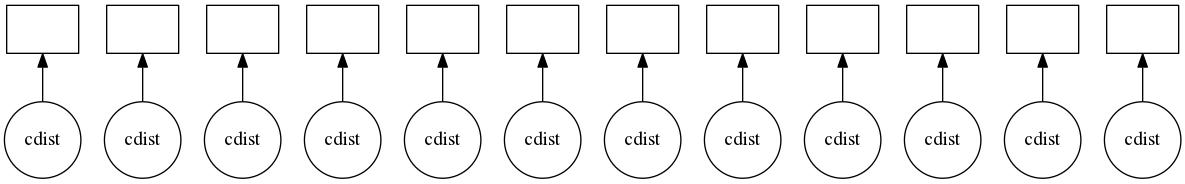

In [12]:
# visualize the copmutational graph
visualize(partial_distances)

In [13]:
cbdm_dask = delayed(np.concatenate)(partial_distances, axis=1)

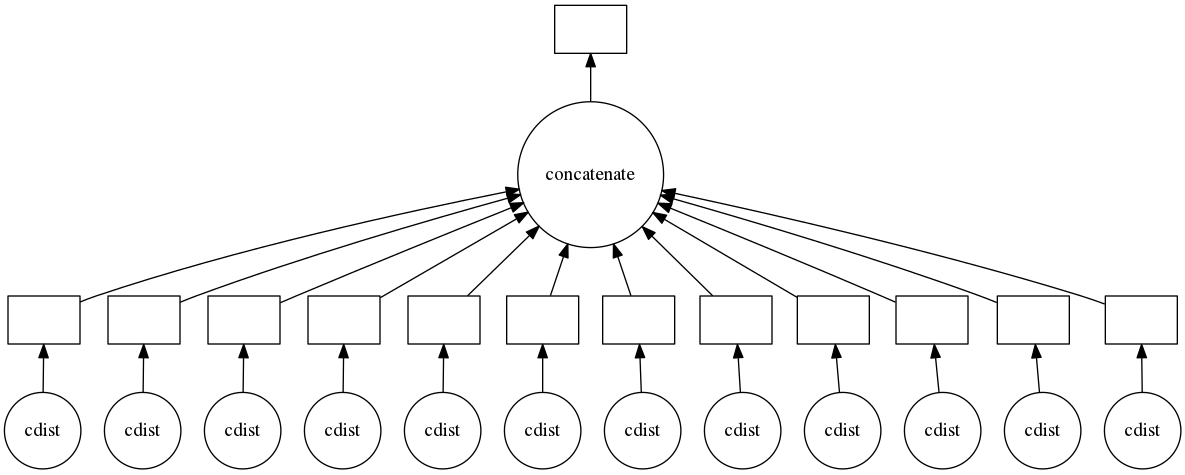

In [14]:
# visualize the copmutational graph
visualize(cbdm_dask)

Let's time the compute step and go to the command `top`. Now you can see that computation is executed in parallel resulting in a shorter execution time.

In [15]:
%timeit compute(cbdm_dask, scheduler='threads')

2.05 s ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# check that the resulting matrices are the same
cbdm = compute(cbdm_dask, scheduler='threads')[0]
np.abs(cbdm - cdist(x, x, 'cityblock')).max()

0.0

A problem with this solution, as mentioned above, is that `np.concatenate` is not  a fast operation.
Let's check how much time it takes without the concatenation part:

In [17]:
%timeit compute(*partial_distances, scheduler='threads')

1.54 s ± 4.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's implement the whole thing as a single function:

In [18]:
def cityblock_dask_concat(x, y, chunks):
    """Implementation using array concatenation"""
    partial_distances = [delayed(cdist)(x, xi, 'cityblock')
              for xi in np.split(x, chunks)]
    cbdm_dask = delayed(np.concatenate)(partial_distances, axis=1)
    return compute(cbdm_dask, scheduler='threads')

In [19]:
print(np.abs(cityblock_dask_concat(x, x, chunks) - cdist(x, x, 'cityblock')).max())

0.0


# Dask arrays

In [20]:
import numpy as np
import dask.array as da

Let's create a random dask array, do some operation and visualize it:

In [21]:
x = da.random.random((2000, 2000), chunks=(500, 500))
x

dask.array<random_sample, shape=(2000, 2000), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>

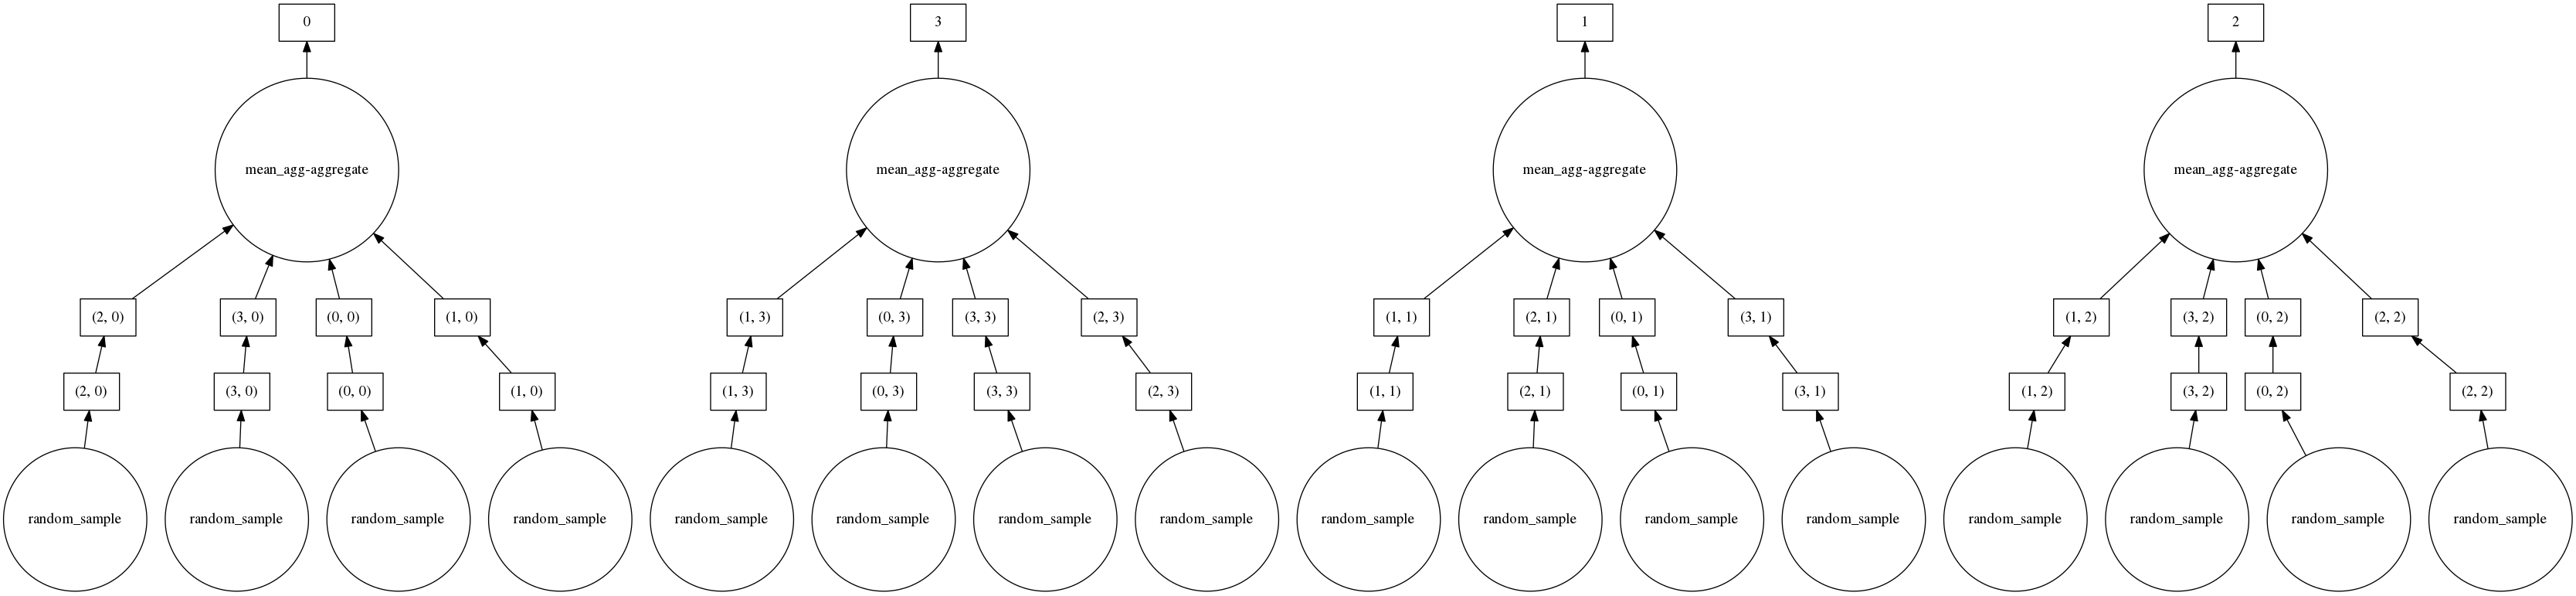

In [22]:
y = x.mean(axis=0)
y.visualize(optimize_graph=True)

Let's increase the size of the array and run the operation.

In [23]:
%%time
x = da.random.random((2000, 2000))
y = x.mean(axis=0)
y.compute().shape

CPU times: user 39.4 ms, sys: 8.26 ms, total: 47.7 ms
Wall time: 46.3 ms


(2000,)

Let's compare the results with NumPy:

In [24]:
%%time 
x = np.random.random((2000, 2000))
y = x.mean(axis=0)
y.shape

CPU times: user 32.9 ms, sys: 11.8 ms, total: 44.7 ms
Wall time: 43.4 ms


(2000,)

Let's consider now the operation `x.dot(x)`. <mark> Question </mark> Could you explain the results of the timings?

In [25]:
%%time 
x = np.random.random((2000, 2000))
y = x.dot(x)
y.shape

CPU times: user 871 ms, sys: 20 ms, total: 891 ms
Wall time: 258 ms


(2000, 2000)

In [26]:
%%time
x = da.random.random((2000, 2000))
y = x.dot(x)
y.compute().shape

CPU times: user 1.17 s, sys: 223 ms, total: 1.4 s
Wall time: 352 ms


(2000, 2000)

# Conclusions
The main points to take home from this notebook are:
  * Dask's delayed execution can be used to make distributed version of functions that run on a single thread.
  * Ditributed version of functions that use OpenMP threads might be slower than the original since the CPU threads need be shared between the concurrent executions of the function.